# FCN VOC 2012 and SBD Semi Supervised Learning

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import my_datasets as mdset
import eval_train as ev
from utils import * 




## Dataset : Pascal VOC 2012

In [2]:
dataroot_voc = '/data/voc2012'
dataroot_sbd = '/data/sbd'
model_name = 'fcn_voc_sbd_unsup_g0_L1'
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,model_name)
save_all_ep = False
batch_size = 3
gamma = 0
criterion_unsupervised = nn.L1Loss(reduction='mean')
KL = False


In [3]:
train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', download=True)
val_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


In [4]:
train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation')

### Concatene Dataset

In [5]:
train_dataset_unsup = tud.ConcatDataset([train_dataset_VOC,train_dataset_SBD])

### Split dataset

In [6]:
train_dataset_sup = split_dataset(train_dataset_unsup,0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([480, 480, 3])


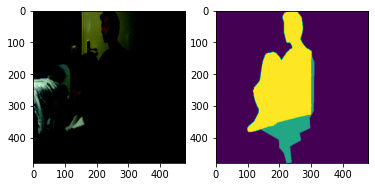

torch.Size([480, 480])

In [7]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = train_dataset_sup.__getitem__(0)
image, mask = sample[0], sample[1]
#print(type(image))
#print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


In [8]:
dataloader_train_sup = torch.utils.data.DataLoader(train_dataset_sup, batch_size=batch_size,\
                                                       shuffle=True,drop_last=True)
dataloader_train_unsup = torch.utils.data.DataLoader(train_dataset_unsup,batch_size=batch_size,\
                                                     shuffle=True,drop_last=True)

dataloader_val = torch.utils.data.DataLoader(val_dataset_VOC, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [9]:
print("Taille dataset train supervised :",len(train_dataset_sup))
print("Taille dataset train unsupervised :",len(train_dataset_unsup))
print("Taille dataset val VOC :",len(val_dataset_VOC))

Taille dataset train supervised : 2126
Taille dataset train unsupervised : 7087
Taille dataset val VOC : 1449



## FCN Pytorch

In [10]:
def load_model(file=None,fcn=False):
    if file is None:
        if fcn is False:
            model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
        else:
            model = torchvision.models.segmentation.fcn_resnet101(pretrained=False)
    else:
        model = torch.load(os.path.join(SAVE_DIR,file))
    return model

In [11]:
model = load_model(fcn=True)

In [12]:
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## Training

In [13]:
learning_rate = 2*10e-4
moment = 0.9
wd = 2e-4
n_epochs = 26
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=wd)
angle_max = 30
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [14]:
#cpt = 0 # cpt for backward every backward_step
iou_test = []
loss_train_unsup = []
loss_test = []
pix_accuracy = []
accuracy_test = []
#

all_loss_train_sup = []
all_pix_accuracy =  []

In [ ]:
torch.autograd.set_detect_anomaly(True)
torch.backends.cudnn.benchmark=True
for ep in range(n_epochs):
    print("EPOCH",ep)

    dataloader_train_unsup = torch.utils.data.DataLoader(train_dataset_unsup,batch_size=batch_size,\
                                                     shuffle=True,drop_last=True)
    model.train()
    for batch_unsup in dataloader_train_unsup:
        optimizer.zero_grad()
        if random.random() > 0.5: # I use this to rotate the image on the left and on the right during training.
            angle = np.random.randint(0,angle_max)
        else:
            angle = np.random.randint(360-angle_max,360)
        x_unsup,_ = batch_unsup
        loss_equiv,acc = compute_transformations_batch(x_unsup,model,angle,reshape=False,\
                                                     criterion=criterion_unsupervised,KL=False,\
                                                       device=device)
        loss_equiv = loss_equiv.to(device) # otherwise bug in combining the loss              
        loss_equiv.backward()
        optimizer.step()
        all_pix_accuracy.append(acc) # accuracy between the original mask and the transform mask put back in place
        all_loss_train_unsup.append(loss_equiv.item())
            
    #lr_scheduler.step()
    
    # average the parameters values
    m_acc = np.array(all_pix_accuracy).mean()
    pix_accuracy.append(m_acc)
    loss_train_unsup.append(np.array(all_loss_train_unsup).mean())

    all_pix_accuracy = []
    all_loss_train_unsup = []
    print("EP:",ep," pixel accuracy between masks ",m_acc,"loss equivariance",loss_equiv.item()) 

    ## Evaluate the  model
    model.eval()
    state = ev.eval_model(model,dataloader_val,device=device,num_classes=21)
    iou = state.metrics['mean IoU']
    acc = state.metrics['accuracy']
    loss = state.metrics['CE Loss']
    print('EP:',ep,'iou:',state.metrics['mean IoU'],\
          'Accuracy:',state.metrics['accuracy'],'Loss CE',state.metrics['CE Loss'])
    loss_test.append(loss)
    iou_test.append(iou)
    accuracy_test.append(acc)
    
    ## Save model
    if save_all_ep:
        save_model = model_name+'_ep'+str(ep)+'.pt'
        save = os.path.join(SAVE_DIR,save_model)
        torch.save(model,save)
    else:
        save_model = model_name+'.pt'
        save = os.path.join(SAVE_DIR,save_model)
        torch.save(model,save)
        

EPOCH 0


/workspace/utils.py:142: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/workspace/utils.py:144: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


loss sup : 3.176856756210327 loss unsup 0.01455862820148468 loss 0.01455862820148468
EP: 0  combine loss train: 0.030534762696398952  pixel accuracy between masks  0.44261517864142363
EP: 0 iou: 0.004444456076334182 Accuracy: 0.006953966926793014 Loss CE 3.077939303518576
EPOCH 1
loss sup : 3.052628755569458 loss unsup 0.009749778546392918 loss 0.009749778546392918
EP: 1  combine loss train: 0.011646941398390457  pixel accuracy between masks  0.3518320688140221
EP: 1 iou: 0.004163768625856754 Accuracy: 0.006876715118771975 Loss CE 3.076316071181893
EPOCH 2


## Plot

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN Unsupervised. Combine loss train")
plt.plot(combine_loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN Unsupervised. Cross entropy loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN Unsupervised. Equivariance loss train")
plt.plot(loss_train_unsup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN Unsupervised. Accuracy train between rotated prediction and original prediction")
plt.plot(pix_accuracy)
plt.xlabel("iterations")
plt.ylabel("Accuracy")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN Unsupervised. Mean iou train ")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN Unsupervised. Mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")